**Código de implementación de una red neuronal que usa la función de pérdida tripleta**

En este cuaderno veremos cómo implementar usando PyTorch una red neuronal que use la función de pérdida tripleta. Empezaremos añadiendo todas las librerías que usaremos.

In [23]:
from fastai.vision import *
from fastai.basics import *
from fastai.vision.all import *
from fastai.vision.augment import *
from fastai.vision.learner import cnn_learner
from fastai.vision.models import resnet34
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders

import torchvision

from scipy import spatial
import logging

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
from numpy.random import RandomState
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import cv2

Definiremos el dispositivo que usaremos. Al definir el dispositivo, nos aseguramos que el modelo se ejecute en la GPU deseada, lo que puede acelerar significativamente el entrenamiento. Si tenemos varias GPUs disponibles, podemos cambiar el valor de dispositivo para usar una GPU diferente.

In [24]:
dispositivo = 0
torch.cuda.set_device(dispositivo)

Ahora procederemos a elegir el dataset con el que trabajaremos. Hemos decidido trabajar con el dataset LFW People. Este dataset contiene 9525 imágenes de entrenamiento y 3708 imágenes de test. Estas imágenes son rostros de personas relativamente famosas. Nuestro objetivo será implementar una red neuronal usando la función de pérdida tripleta que, dada una imagen de entrada, devuelva las imágenes que más se parezcan a la de entrada de una base de datos (que puede en principio NO contener la imagen original).

Una red neuronal así puede ser de gran utilidad en campos en los que es necesario reconocer a cierta persona (de la que tenemos al menos alguna foto normalmente) en un gran conjunto de fotos.

In [25]:
from torch.utils.data import Subset

# Definimos transformaciones (redimensionar y normalizar las imágenes)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Descargamos y cargamos el dataset de entrenamiento de LFW People
lfw_dataset = datasets.LFWPeople(root='./data', split='train', download=True, transform=transform)


# Seleccionar 2200 índices aleatorios del dataset
num_instances = 2200
total_instances = len(lfw_dataset)
indices = random.sample(range(total_instances), num_instances)

# Crear un subconjunto con los índices seleccionados
lfw_subset = Subset(lfw_dataset, indices)

# Mostrar información del subset
print(f"Dataset original: {total_instances} instancias")
print(f"Subset: {len(lfw_subset)} instancias seleccionadas")

Files already downloaded and verified
Dataset original: 9525 instancias
Subset: 2200 instancias seleccionadas


Reusaremos un par de funciones que ya usamos antes en las prácticas de la asignatura. Estas funciones las podemos usar tal cual nos fueron dadas por los profesores de las prácticas ya que estamos en un contexto con una base de datos similar. Estas las usaremos una (`rangeDisplay01()`) para normalizar las imágenes y la otra (`displayIm()`) para mostrarlas.

In [26]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [27]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im,factor= 1):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  # Transpose the image to change the order of dimensions from CHW to HWC
  im = im.transpose(1, 2, 0)  # Assuming im has shape (C, H, W)

  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

Mostremos la primera imagen de nuestro dataset LFW

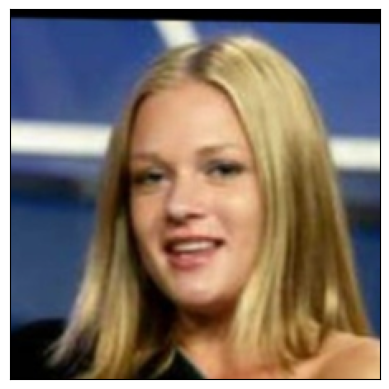

In [28]:
# Obtenemos la imagen y su etiqueta accediendo al primer elemento de lfw_dataset
image, label = lfw_dataset[0]

# Normalizamos la imagen usando la función rangeDisplay01()
processed_image = rangeDisplay01(image.numpy())

# Mostramos la imagen usando la función displayIm()
displayIm(processed_image)

En cuanto a la longitud de los fingerprints/embeddings que hallemos decidiremos usar un valor de 256. Este valor hemos visto que se usa bastante en problemas similares al nuestro.

In [29]:
embedding_long = 256

Ahora procederemos a declarar el modelo que usaremos como base. En nuestro caso, hemos decidido que ResNet18 es un modelo lo suficientemente profundo y complejo como para realizar la tarea que queremos sin tampoco ser excesivamente complejo. Usaremos también los pesos que tuviera ya entrenados.

In [30]:
pretrained_resnet = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Queremos sustituir ahora el "head" (cabeza en español) del modelo preentrenado ResNet18 por un head que tenga una longitud de embedding/fingerprint apropiada para nuestro problema. Antes hemos dicho que esta sería de 256.

 Además, crearemos también una clase que representa una capa que normaliza los valores entrantes entre 0 y 1 llamando a la función `normalize()`.

In [31]:
class Norm_L2(nn.Module):
    def __init__(self):
        super(Norm_L2, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

Sustituimos ahora el head de nuestro modelo preentrenado ResNet18 por el head apropiado para nuestro problema. Este head se compone de una capa Fully Connected (FC) con el mismo número de características de entrada que tenía el head original y con un nuevo número de características de salida que será el apropiado para nuestro problema (256) y la capa de normalización que acabamos de definir.

In [32]:
custom_head = nn.Sequential(
    nn.Linear(in_features=pretrained_resnet.fc.in_features, out_features=embedding_long, bias=True),
    Norm_L2()
)

pretrained_resnet.fc = custom_head


Mostremos como sería el modelo que vamos a entrenar finalmente.

In [33]:
pretrained_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Implementemos ahora la clase TripletDataset. Esta clase nos servirá para gestionar la manera en la que obtendremos las tripletas de imágenes. El constructor `init` toma como parámetros un dataset con imágenes y un modelo (y adicionalmente el valor del margen si queremos).

En este constructor también se crea el objeto `label_to_indices`. Este objeto es un diccionario que se utiliza para almacenar los índices de las imágenes del dataset que pertenecen a cada etiqueta, de manera que los índices de las imágenes con la misma etiqueta se almacenan juntos (por su etiqueta). Veamos un ejemplo de la forma de `label_to_indices` con nuestro dataset LFW People:

{0: [0], 2: [1], 4: [2], 5: [3, 4, 5, 6], 6: [7], 7: [8, 9], 10: [10], 11: [11], 12: [12], 13: [13, 14], 14: [15, 16, 17, 18], 16: [19], ...

En cuanto al método `getitem`, este gestiona el proceso de selección de tripletas para el aprendizaje de métricas. Para un índice dado, selecciona una muestra como ancla (anchor) junto con su etiqueta. Luego, elige una muestra positiva al azar con la misma etiqueta y calcula sus embeddings utilizando el modelo de la clase. Después, busca una muestra negativa semi-dura, es decir, una que tenga una etiqueta diferente y cuya distancia al ancla esté entre la distancia del ancla con la positiva (pos_distance) y la suma de esta distancia con un margen predefinido (pos_distance + margin). Esto asegura que el modelo aprenda a diferenciar correctamente entre clases cercanas pero manteniendo una separación útil para la clasificación.

In [34]:
class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, model, margin=0.2):
        self.dataset = dataset
        self.label_to_indices = {}
        self.model = model
        self.margin = margin

        # Crear un diccionario que asocia cada etiqueta con los índices de los datos que tienen esa etiqueta
        for idx, (_, label) in enumerate(self.dataset):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

    def __getitem__(self, index):
        # Obtener el ancla (anchor) y su etiqueta
        anchor, label = self.dataset[index]

        # Obtener un índice para una muestra positiva (con la misma etiqueta que el ancla)
        positive_idx = random.choice(self.label_to_indices[label])
        positive = self.dataset[positive_idx][0]  # Obtener el tensor de imagen de la muestra positiva

        # Obtener embeddings para el ancla y la muestra positiva
        anchor_tensor = anchor.unsqueeze(0)  # Añadir dimensión de lote
        positive_tensor = positive.unsqueeze(0)  # Añadir dimensión de lote

        with torch.no_grad():
            anchor_embedding = self.model(anchor_tensor.cuda())
            positive_embedding = self.model(positive_tensor.cuda())

        # Calcular la distancia entre el ancla y la muestra positiva
        pos_distance = F.pairwise_distance(anchor_embedding, positive_embedding)

        # Seleccionar una muestra negativa semi-dura
        negative = None
        negative_label = random.choice(list(self.label_to_indices.keys()))

        # Asegurar que la etiqueta negativa sea diferente a la etiqueta del ancla
        while negative_label == label:
            negative_label = random.choice(list(self.label_to_indices.keys()))

        # Buscar una muestra negativa semi-dura
        for neg_idx in self.label_to_indices[negative_label]:
            negative = self.dataset[neg_idx][0]  # Obtener el tensor de imagen de la muestra negativa
            negative_tensor = negative.unsqueeze(0)  # Añadir dimensión de lote

            with torch.no_grad():
                negative_embedding = self.model(negative_tensor.cuda())

            # Calcular la distancia entre el ancla y la muestra negativa
            neg_distance = F.pairwise_distance(anchor_embedding, negative_embedding)

            # Verificar si la muestra negativa es semi-dura
            if neg_distance < pos_distance + self.margin and neg_distance > pos_distance:
                break  # Encontró una muestra negativa semi-dura

        return anchor, positive, negative

    def __len__(self):
        return len(self.dataset)


Implementaremos ahora la clase `TripletLoss` que representa la función de pérdida tripleta. En esta clase distinguimos el constructor `init` y la función `forward`. Esta última calcula la distancia entre el ancla y la muestra positiva (pos_dist), así como entre el ancla y la muestra negativa (neg_dist). La pérdida se define como la diferencia entre estas distancias más un margen, aplicado a través de la función ReLU para evitar valores negativos. Por último, retorna el promedio de la pérdida para todas las tripletas del lote, promoviendo que las distancias positivas sean menores que las negativas por al menos el margen definido.

In [35]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

Procedemos ya a intentar entrenar nuestro modelo preentrenado ResNet18. Para empezar, asignamos un modelo ResNet18 preentrenado (pretrained_resnet) a la GPU utilizando .cuda() para acelerar los cálculos. Luego, definimos la función de pérdida `criterion` como una instancia de la clase TripletLoss. Por último, creamos un optimizador Adam para actualizar los parámetros del modelo durante el entrenamiento, con una tasa de aprendizaje de 0.0005, asegurando así actualizaciones graduales de los pesos y una mejora de la convergencia.

In [36]:
model = pretrained_resnet.cuda()
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Vamos a realizar ya el entrenamiento del modelo.

Antes, primero creamos un dataset de tripletas utilizando nuestra clase `TripletDataset`, que genera imágenes ancla, positiva y negativa a partir del dataset `lfw_dataset`. Luego, creamos un objeto DataLoader que organiza los datos en batches de tamaño 32, activando el barajado usando el parámetro `shuffle=True` para conseguir más variabilidad en las iteraciones.

Empezamos ya con el entrenamiento en sí. Realizaremos un entrenamiento de 10 épocas. Es un número para el que hemos visto que el modelo deja de reducir significativamente la función de pérdida. En cada una de las 10 épocas de entrenamiento, realizaremos lo siguiente:

Para cada batch del `train_loader`, cargaremos las tripletas (ancla, positiva y negativa) en la GPU.
Obtendremos los embeddings correspondientes al ancla, la positiva y la negativa pasando las respectivas imágenes por nuestro modelo en proceso de entrenamiento.
Calculamos ahora la pérdida de la tripleta utilizando la función de pérdida (criterion) definida justo antes. Ahora, reiniciamos los gradientes de los parámetros del modelo a cero usando la función `optimizer.zero_grad()`.
Lo siguiente que haremos será realizar una "pasada hacia atrás" (usando la función loss.backward()) para calcular los gradientes y luego actualizamos los parámetros del modelo a los nuevos usando el optimizador y su función `optimizer.step()`.
Además, en cada época iremos acumulando la pérdida registrada para poder monitorear el progreso del modelo.
Por último, iremos imprimiendo por pantalla esa pérdida promedio de cada época.








In [ ]:
# Creamos el TripletDataset y el DataLoader
triplet_dataset = TripletDataset(lfw_dataset, model)
train_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

for epoch in range(10):
    epoch_loss = 0
    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        # Realizamos el forward pass
        anchor_embeddings = model(anchor)
        positive_embeddings = model(positive)
        negative_embeddings = model(negative)

        # Calculamos la pérdida
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/10], Loss: {epoch_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 0.0380
Epoch [2/10], Loss: 0.0266
Epoch [3/10], Loss: 0.0234
Epoch [4/10], Loss: 0.0191
Epoch [5/10], Loss: 0.0168
Epoch [6/10], Loss: 0.0162
Epoch [7/10], Loss: 0.0145
Epoch [8/10], Loss: 0.0131
Epoch [9/10], Loss: 0.0118
Epoch [10/10], Loss: 0.0119


Observamos que hemos conseguido reducir considerablemente el valor de la función de pérdida. Veaamos ahora la primera imagen del dataset LFW People almacenado en `lfw_dataset` de nuevo:

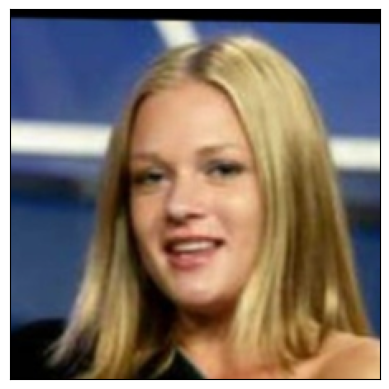

In [ ]:
image_consulta, label = lfw_dataset[0]
processed_image = rangeDisplay01(image_consulta.numpy())
displayIm(processed_image)

Una vez tenemos ya el modelo entrenado, podemos plantearnos finalmente implementar una función que lleve a cabo la tarea que queríamos desde el principio: a partir de una imagen de entrada de un rostro humano y una base de datos de imágenes del mismo tipo intentar predecir qué imágenes de la base de datos son de individuos parecidos o hasta del mismo. Esta función será `predict_top_n()`. Los parámetros de esta son:

`input_tensor`: Especifica el tensor de la imagen de entrada
`model`: Especifica el modelo que se usara para hallar las predicciones
`dataset`: Especifica la base de datos de imágenes en la que se buscará.
`n`: Especifica el número de predicciones que deseamos obtener. Hay que tener en cuenta que estarán ordenadas de mejor a peor, siendo la mejor la primera.

La función devolverá una lista de longitud `n` que en cada posición tiene otra lista que en cada posición tiene:
- La imagen número N más similar a la de entrada del conjunto de datos.
- La puntuación de similitud (de coseno) para esa imagen y la de entrada.
- El embedding de esta imagen número N más similar.
- El índice de esta imagen en el conjunto de datos.

En cuanto al funcionamiento interno de esta función bastará con fijarse en los comentarios añadidos, ya que son bastante explicativos y así no perderemos el guión de lo que queremos ir haciendo.

In [10]:
def predict_top_n(input_tensor, model, dataset, n=5):
    # Obtener el dispositivo donde está el modelo (CPU o GPU)
    device = next(model.parameters()).device

    # Mover el tensor de entrada al dispositivo del modelo
    input_tensor = input_tensor.to(device)

    # Si el tensor de entrada tiene 3 dimensiones (por ejemplo, una imagen sin batch),
    # agregar una dimensión extra para representar el batch.
    if input_tensor.dim() == 3:
        input_tensor = input_tensor.unsqueeze(0)

    # Desactivar el cálculo de gradientes para ahorrar memoria y mejorar el rendimiento
    with torch.no_grad():
        # Obtener el embedding de la imagen de entrada usando el modelo
        output_embedding = model(input_tensor)

    # Inicializar las listas para guardar las imágenes similares y los embeddings
    similarities = []
    embeddings = []

    # Recorrer todas las imágenes en el conjunto de datos
    for i in range(len(dataset)):
        # Obtener la imagen y su etiqueta (aunque no necesitamos la etiqueta aquí)
        image, _ = dataset[i]

        # Agregar una dimensión extra al tensor de la imagen y mover al dispositivo
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            # Calcular el embedding de la imagen del conjunto de datos
            embedding = model(image)

        # Calcular la similitud coseno entre el embedding de entrada y el de la imagen del conjunto de datos
        similarity = torch.cosine_similarity(output_embedding, embedding).item()

        # Guardar la similitud junto con el índice de la imagen en el conjunto de datos
        similarities.append((similarity, i))

        # Guardar el embedding de la imagen en el conjunto de datos
        embeddings.append(embedding)

    # Ordenar las similitudes en orden descendente (de mayor a menor similitud)
    similarities.sort(key=lambda x: x[0], reverse=True)

    # Obtener las N mejores similitudes
    top_n_similarities = similarities[:n]

    # Preparar los resultados
    results = []
    for similarity, index in top_n_similarities:
        results.append((dataset[index][0], similarity, embeddings[index], index))

    # Retornar los resultados finales
    return results

Ha llegado por fin el momento de finalmente probar nuestra función `predict_top_n` usando como entrada la primera imagen del dataset `lfw_dataset`, como modelo nuestro modelo ya entrenado `model` y como dataset `lfw_dataset` también. Lo que esperamos es encontrar que la primera imagen que obtengamos sea la misma imagen que la de entrada. Veamos qué obtenemos

In [ ]:
resultado = predict_top_n(image_consulta, model, lfw_dataset)

Veamos la imagen que más se parece

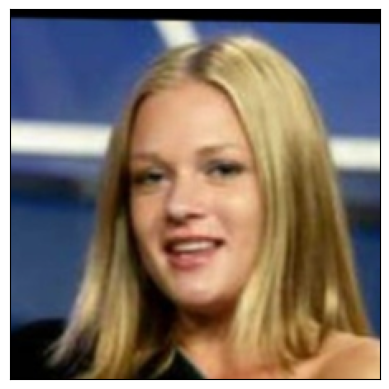

In [ ]:
processed_resultado = rangeDisplay01(resultado[0][0].numpy())
displayIm(processed_resultado)

Tal y como esperábamos es la misma imagen. Veamos la segunda, tercera, cuarta y quinta.

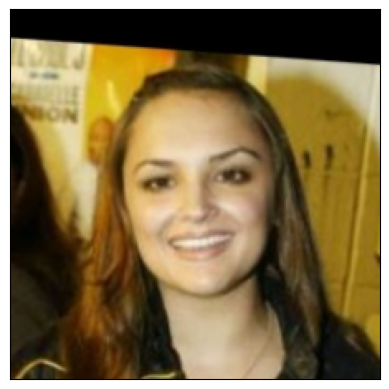

In [ ]:
processed_resultado = rangeDisplay01(resultado[1][0].numpy())
displayIm(processed_resultado)

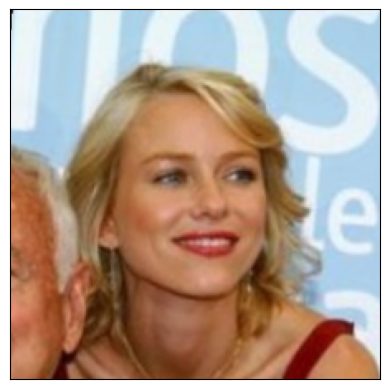

In [ ]:
processed_resultado = rangeDisplay01(resultado[2][0].numpy())
displayIm(processed_resultado)

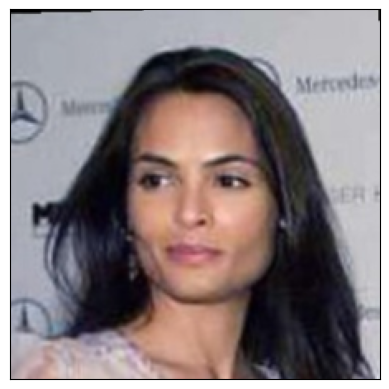

In [ ]:
processed_resultado = rangeDisplay01(resultado[3][0].numpy())
displayIm(processed_resultado)

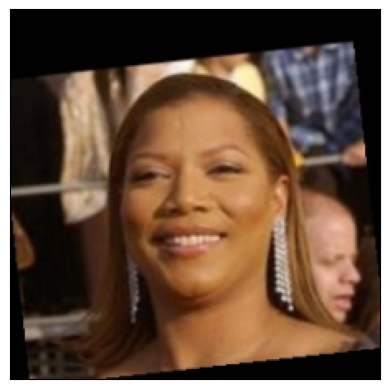

In [ ]:
processed_resultado = rangeDisplay01(resultado[4][0].numpy())
displayIm(processed_resultado)

En general, podríamos decir que, aunque no parezcan la misma persona, nuestro modelo ha obtenido imágenes con ciertos parecidos a la imagen original. Todas las imágenes obtenidas son mujeres, rubias y con el pelo medianamente largo.

Veamos ahora cómo podemos medir de una manera algo más objetiva qué tan bueno es nuestro modelo encontrando imágenes parecidas. La idea es obtener `m` conjuntos de predicciones distintas cada uno de `n` imágenes y calcular la distancia media de todas estas predicciones a sus respectivas imágenes de entrada. Cuanto mayor sea `m`, más representativo debería ser este valor medio. Sin embargo, no pasa igual con `n`. Realmente el dataset que usamos es bastante desbalanceado y lo mismo no hay ni si quiera 10 imágenes que se parezcan algo a la de entrada. Intentaremos usar valores de `n` bajos, e idealmente 1. Implementaremos la función `evaluate` que hace lo que acabamos de describir. Los parámetros de entrada serán el modelo, el dataset, el `m` y el `n`. Lo que devuelve la función es este valor medio que lo usaremos como medida de la corrección de las predicciones del modelo.

In [ ]:
import random

def evaluate(model, dataset, m, n):

    total_distance = 0
    j = 0

    for _ in range(m):
        # Seleccionar una imagen de entrada aleatoria
        random_index = random.randint(0, len(dataset) - 1)
        input_image, _ = dataset[random_index]

        # Obtener las n predicciones más cercanas
        predictions = predict_top_n(input_image, model, dataset, n)

        # Calcular la distancia media para esta imagen de entrada
        distance_sum = 0
        i = 0
        for prediction, _, _, _ in predictions:
            # Usamos la distancia L1 (Manhattan) como métrica de distancia
            distance = torch.mean(torch.abs(input_image - prediction))
            distance_sum += distance
            print("Distancia de la predicción " + str(j) + " , " + str(i) + ": " + str(distance))
            i += 1

        total_distance += distance_sum / n
        print("Distancia media de la predicción " + str(j) + ": " + str(distance_sum/n))
        j += 1

    # Calcular la distancia media total
    average_distance = total_distance / m
    print("Distancia media de las predicciones: " + str(average_distance))

    return average_distance

Lo correcto sería probar qué tan bueno es nuestro modelo en una base de datos de imágenes que NO contenga la imagen de entrada. Veamos qué tan buenas son las imágenes predichas en el dataset `lfw_test`, que es la partición de test del dataset LFW People.

In [11]:
lfw_test = datasets.LFWPeople(root='./data', split='test', download=True, transform=transform)
print(f"Número de imágenes: {len(lfw_test)}")

Using downloaded and verified file: ./data/lfw-py/lfw-funneled.tgz
Extracting ./data/lfw-py/lfw-funneled.tgz to ./data/lfw-py


100%|██████████| 28.3k/28.3k [00:00<00:00, 127kB/s]


Using downloaded and verified file: ./data/lfw-py/lfw-names.txt
Número de imágenes: 3708


Hagamos las nuevas predicciones de la misma imagen de entrada que antes y veamos qué imágenes obtiene nuestro modelo.

In [ ]:
resultadoTest = predict_top_n(image_consulta, model, lfw_test)

Veamos la más parecida.

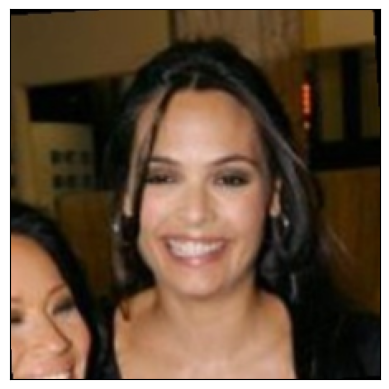

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest[0][0].numpy())
displayIm(processed_resultado)

De nuevo observamos una mujer con el pelo medianamente largo. Veamos ahora las imágenes segunda, tercera, cuarta y quinta.

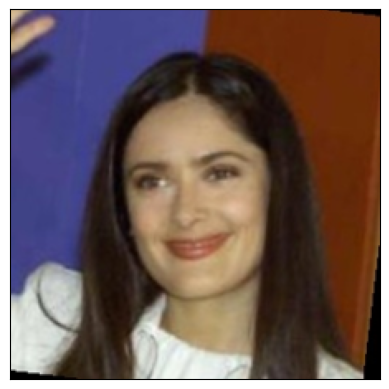

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest[1][0].numpy())
displayIm(processed_resultado)

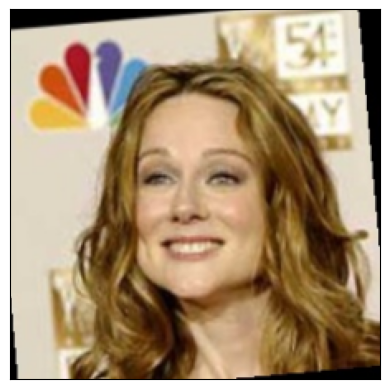

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest[2][0].numpy())
displayIm(processed_resultado)

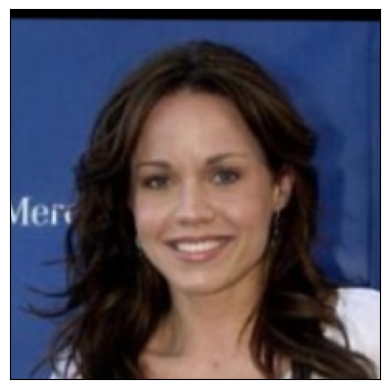

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest[3][0].numpy())
displayIm(processed_resultado)

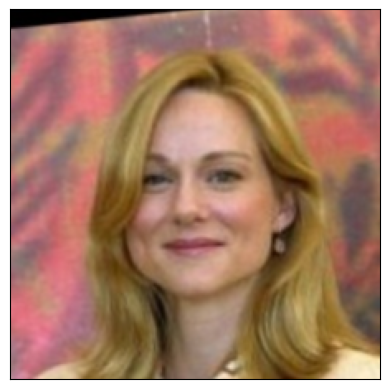

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest[4][0].numpy())
displayIm(processed_resultado)

Observamos que, ahora en un dataset completamente nuevo para el modelo, volvemos a obtener imágenes de mujeres, rubias con el pelo relativamente largo. Sin embargo, hay una que nos llama la atención.

Veamos otro ejemplo usando ahora otra imagen de entrada.

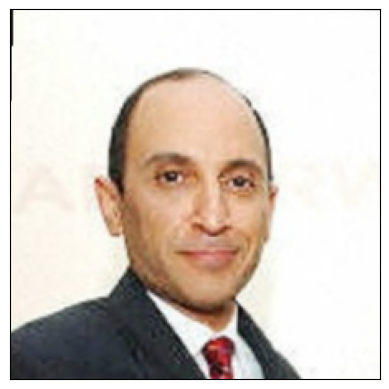

In [ ]:
image_consulta2 = lfw_dataset[90][0]
processed_image = rangeDisplay01(image_consulta2.numpy())
displayIm(processed_image)

Observamos un hombre, de edad mediana, raza blanca, medianamente calvo y algo de frente. Veamos qúe imágenes obtenemos en el dataset nuevo.

In [ ]:
resultadoTest2 = predict_top_n(image_consulta2, model, lfw_test)

Veamos la imagen más parecida.

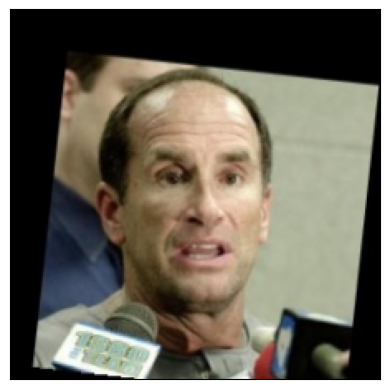

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest2[0][0].numpy())
displayIm(processed_resultado)

La imagen más parecida realmente tiene parecidos. Observamos otro individuo hombre, de edad mediana, raza blanca, algo calvo y con frente notable. Veamos ahora las imágenes segunda, tercera, cuarta y quinta.

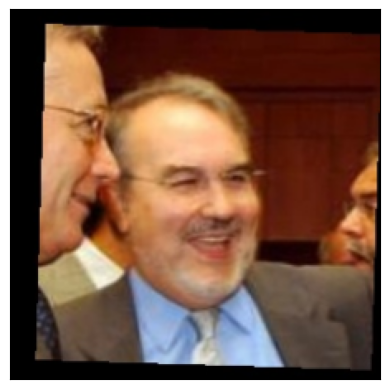

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest2[1][0].numpy())
displayIm(processed_resultado)

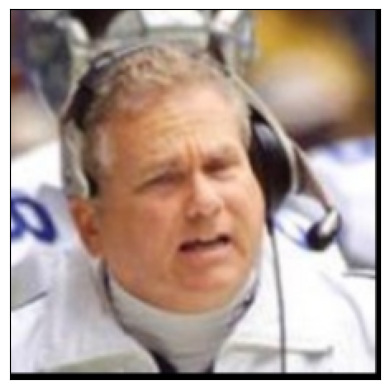

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest2[2][0].numpy())
displayIm(processed_resultado)

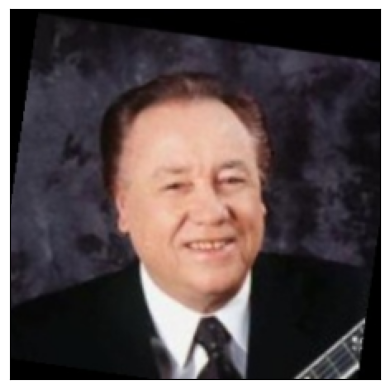

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest2[3][0].numpy())
displayIm(processed_resultado)

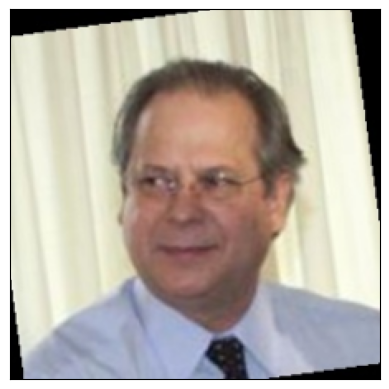

In [ ]:
processed_resultado = rangeDisplay01(resultadoTest2[4][0].numpy())
displayIm(processed_resultado)

Observamos que en general en todas las imágenes podemos ver hombres de mediana edad, raza blanca, con falta de pelo y una frente prominente. La segunda imagen más parecida puede que tenga más pelo del que debería, pero en general son imágenes parecidas.

Usemos ya finalmente esta función `evaluate` que definimos anteriormente para ver qué tan bueno es nuestro modelo prediciendo imágenes similares. Como destacamos antes, escogeremos un valor alto (50) para `m` y un valor de $1$ para `n`. Además, probaremos en el conjunto de test y no en el de entrenamiento, para intentar hacerlo más realista.

In [ ]:
metrica = evaluate(model, lfw_test, 30, 3)

Distancia de la predicción 0 , 0: tensor(0.)
Distancia de la predicción 0 , 1: tensor(0.2399)
Distancia de la predicción 0 , 2: tensor(0.2198)
Distancia media de la predicción 0: tensor(0.1532)
Distancia de la predicción 1 , 0: tensor(0.)
Distancia de la predicción 1 , 1: tensor(0.2989)
Distancia de la predicción 1 , 2: tensor(0.3590)
Distancia media de la predicción 1: tensor(0.2193)
Distancia de la predicción 2 , 0: tensor(0.)
Distancia de la predicción 2 , 1: tensor(0.2979)
Distancia de la predicción 2 , 2: tensor(0.1982)
Distancia media de la predicción 2: tensor(0.1653)
Distancia de la predicción 3 , 0: tensor(0.)
Distancia de la predicción 3 , 1: tensor(0.2058)
Distancia de la predicción 3 , 2: tensor(0.2314)
Distancia media de la predicción 3: tensor(0.1458)
Distancia de la predicción 4 , 0: tensor(0.)
Distancia de la predicción 4 , 1: tensor(0.3245)
Distancia de la predicción 4 , 2: tensor(0.3187)
Distancia media de la predicción 4: tensor(0.2144)
Distancia de la predicción 5 ,

Hemos obtenido un valor que parece prometedor. Sin embargo, la pregunta ahora es realmente cómo usamos este valor para poder determinar qué tan bueno es nuestro modelo en esta tarea.

Lo que haremos será aplicar el método de `evaluate` en el mismo dataset usado antes, pero ahora en vez de usar el modelo para predecir las imágenes de salida escogeremos estas de manera completamente aleatoria. Después, podremos comparar los valores obtenidos por `evaluate` para nuestro modelo y lfw_test y por esta nueva función `evaluate_random` para lfw_test.

Esta nueva función `evaluate_random` sigue una lógica similar a `evaluate` con la única diferencia que acabamos de mencionar a la hora de escoger las imágenes de salida.

Esperamos obtener una distancia media menor cuando usemos el modelo en comparación con la obtenida al usar imágenes completamente aleatorias. Además, veremos en qué porcentaje disminuye esta distancia el uso de nuestro red. De esta manera, podemos decir de una manera algo más objetiva que antes qué tan bueno es nuestro modelo. No nos limitaremos únicamente a ver a ojo que se parecen las imágenes.

In [ ]:
def evaluate_random(dataset, m, n):

    total_distance = 0
    j = 0

    for _ in range(m):
        # Seleccionar una imagen de entrada aleatoria
        random_index = random.randint(0, len(dataset) - 1)
        input_image, _ = dataset[random_index]

        # Seleccionar n imágenes aleatorias para comparar
        random_indices = random.sample(range(len(dataset)), n)
        random_images = [dataset[i][0] for i in random_indices]

        # Calcular la distancia media para esta imagen de entrada
        distance_sum = 0
        i = 0
        for image in random_images:
            # Usamos la distancia L1 (Manhattan) como métrica de distancia
            distance = torch.mean(torch.abs(input_image - image))
            distance_sum += distance
            print("Distancia de la predicción " + str(j) + " , " + str(i) + ": " + str(distance))
            i += 1

        total_distance += distance_sum / n
        print("Distancia media de la predicción " + str(j) + ": " + str(distance_sum/n))
        j += 1

    # Calcular la distancia media total
    average_distance = total_distance / m
    print("Distancia media de las predicciones " + str(average_distance))

    return average_distance

Veamos la distancia media obtenida de la predicciones a la imagen de entrada escogiendo estas predicciones de manera completamente aleatoria.

In [ ]:
metrica_random = evaluate_random(lfw_test, 30, 3)

Distancia de la predicción 0 , 0: tensor(0.2965)
Distancia de la predicción 0 , 1: tensor(0.2905)
Distancia de la predicción 0 , 2: tensor(0.2522)
Distancia media de la predicción 0: tensor(0.2797)
Distancia de la predicción 1 , 0: tensor(0.2171)
Distancia de la predicción 1 , 1: tensor(0.2907)
Distancia de la predicción 1 , 2: tensor(0.2811)
Distancia media de la predicción 1: tensor(0.2630)
Distancia de la predicción 2 , 0: tensor(0.2245)
Distancia de la predicción 2 , 1: tensor(0.3135)
Distancia de la predicción 2 , 2: tensor(0.2849)
Distancia media de la predicción 2: tensor(0.2743)
Distancia de la predicción 3 , 0: tensor(0.3721)
Distancia de la predicción 3 , 1: tensor(0.3336)
Distancia de la predicción 3 , 2: tensor(0.2945)
Distancia media de la predicción 3: tensor(0.3334)
Distancia de la predicción 4 , 0: tensor(0.1776)
Distancia de la predicción 4 , 1: tensor(0.2538)
Distancia de la predicción 4 , 2: tensor(0.1766)
Distancia media de la predicción 4: tensor(0.2027)
Distancia 

Vemos que la diferencia que hemos obtenido es de poco más de 0.5. Esta diferencia es bastante notable, siendo alrededor de un 70% más alto el valor obtenido para una evaluación aleatoria si lo comparamos con el obtenido usando el modelo. La conclusión que obtenemos es que el modelo funciona al menos mejor que uno aleatorio.

In [16]:
def evaluate(model, test_loader, threshold):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            output1 = model(img1)
            output2 = model(img2)

            euclidean_distance = torch.pairwise_distance(output1, output2)
            predictions = (euclidean_distance < threshold).float()

            total_samples += label.size(0)
            total_correct += (predictions == label).sum().item()

    accuracy = total_correct / total_samples
    print(f'Accuracy: {accuracy * 100:.2f}%')

def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [18]:
test_dataset = datasets.LFWPairs(root='./data', split='test', transform=transform, download=True)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using downloaded and verified file: ./data/lfw-py/lfw-funneled.tgz
Extracting ./data/lfw-py/lfw-funneled.tgz to ./data/lfw-py


100%|██████████| 26.0k/26.0k [00:00<00:00, 114kB/s]


In [ ]:
thresholds = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for threshold in thresholds:
    print(f"\nThreshold: {threshold}")
    evaluate(model, test_loader, threshold)


Threshold: 0.65
Accuracy: 79.70%

Threshold: 0.7
Accuracy: 82.40%

Threshold: 0.75
Accuracy: 83.70%

Threshold: 0.8
Accuracy: 84.40%

Threshold: 0.85
Accuracy: 84.40%

Threshold: 0.9
Accuracy: 83.60%


Probemos ahora con distintos tamaños para los embeddings y comparemos:

$$$$

**Tamaño 128**


In [ ]:
embedding_long = 128

pretrained_resnet = torchvision.models.resnet18(pretrained=True)

custom_head = nn.Sequential(
    nn.Linear(in_features=pretrained_resnet.fc.in_features, out_features=embedding_long, bias=True),
    Norm_L2()
)

pretrained_resnet.fc = custom_head

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model128 = pretrained_resnet.cuda()
criterion = TripletLoss()
optimizer = optim.Adam(model128.parameters(), lr=0.0005)

In [ ]:
# Creamos el TripletDataset y el DataLoader
triplet_dataset = TripletDataset(lfw_dataset, model128)
train_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

for epoch in range(10):
    epoch_loss = 0
    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        # Realizamos el forward pass
        anchor_embeddings = model128(anchor)
        positive_embeddings = model128(positive)
        negative_embeddings = model128(negative)

        # Calculamos la pérdida
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/10], Loss: {epoch_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 0.0368
Epoch [2/10], Loss: 0.0259
Epoch [3/10], Loss: 0.0212
Epoch [4/10], Loss: 0.0207
Epoch [5/10], Loss: 0.0174
Epoch [6/10], Loss: 0.0115
Epoch [7/10], Loss: 0.0067
Epoch [8/10], Loss: 0.0075
Epoch [9/10], Loss: 0.0099
Epoch [10/10], Loss: 0.0059


In [ ]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for threshold in thresholds:
    print(f"\nThreshold: {threshold}")
    evaluate(model128, test_loader, threshold)


Threshold: 0.5
Accuracy: 78.80%

Threshold: 0.55
Accuracy: 79.00%

Threshold: 0.6
Accuracy: 79.10%

Threshold: 0.65
Accuracy: 78.40%

Threshold: 0.7
Accuracy: 75.60%

Threshold: 0.75
Accuracy: 72.50%


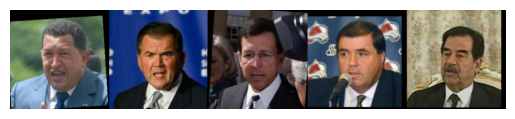

In [ ]:
dataloader = DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size= 1)
image_to_compare, _, _ = next(iter(dataloader))

resultado = predict_top_n(image_to_compare, model128, lfw_dataset)

image_tensors = [result[0] for result in resultado]
concatenated = torch.cat(image_tensors, dim=2)
imshow(concatenated)

**Tamaño 64 de embedding**

In [12]:
embedding_long = 64

pretrained_resnet = torchvision.models.resnet18(pretrained=True)

custom_head = nn.Sequential(
    nn.Linear(in_features=pretrained_resnet.fc.in_features, out_features=embedding_long, bias=True),
    Norm_L2()
)

pretrained_resnet.fc = custom_head

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


In [13]:
model64 = pretrained_resnet.cuda()
criterion = TripletLoss()
optimizer = optim.Adam(model64.parameters(), lr=0.0005)

In [14]:
# Creamos el TripletDataset y el DataLoader
triplet_dataset = TripletDataset(lfw_dataset, model64)
train_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

for epoch in range(10):
    epoch_loss = 0
    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        # Realizamos el forward pass
        anchor_embeddings = model64(anchor)
        positive_embeddings = model64(positive)
        negative_embeddings = model64(negative)

        # Calculamos la pérdida
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/10], Loss: {epoch_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 0.0409
Epoch [2/10], Loss: 0.0264
Epoch [3/10], Loss: 0.0223
Epoch [4/10], Loss: 0.0151
Epoch [5/10], Loss: 0.0062
Epoch [6/10], Loss: 0.0078
Epoch [7/10], Loss: 0.0108
Epoch [8/10], Loss: 0.0101
Epoch [9/10], Loss: 0.0064
Epoch [10/10], Loss: 0.0071


In [21]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

for threshold in thresholds:
    print(f"\nThreshold: {threshold}")
    evaluate(model64, test_loader, threshold)


Threshold: 0.4
Accuracy: 77.50%

Threshold: 0.45
Accuracy: 78.50%

Threshold: 0.5
Accuracy: 77.60%

Threshold: 0.55
Accuracy: 76.00%

Threshold: 0.6
Accuracy: 75.10%

Threshold: 0.65
Accuracy: 73.50%


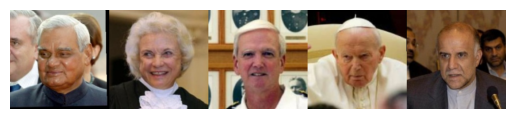

In [22]:
dataloader = DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size= 1)
image_to_compare, _, _ = next(iter(dataloader))

resultado = predict_top_n(image_to_compare, model64, lfw_dataset)

image_tensors = [result[0] for result in resultado]
concatenated = torch.cat(image_tensors, dim=2)
imshow(concatenated)